In [1]:
import sys
sys.path.append('./')
sys.path.append('./../../../../')
sys.path.append('./../../../../designer')
sys.path.append('./../../../../designer/script')

from spectrum import Spectrum
from film import MultiMaterialFilm
from optimizer.adam import AdamThicknessOptimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from design import BaseDesign

from utils.substitute import optimal_and_thin_film_approx_substitution_onestep_new, equal_optical_thickness_new

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
wls = np.linspace(390, 710, 320)
wls_more = np.linspace(300, 800, 500)

target_spec_params = 0., wls
target = Spectrum(*target_spec_params, np.zeros_like(wls))

reverse = lambda arr: np.ascontiguousarray(np.flip(arr))
d_init = reverse(np.loadtxt('./before')) # NOTE: the structures are in the reverse order
materials_init = reverse(np.loadtxt('./before_materials', dtype='str'))
d_eqot_benchmark = reverse(np.loadtxt('./after'))
materials_eqot_benchmark = reverse(np.loadtxt('./after_materials', dtype='str'))

print(materials_init)
print(d_init)
print(d_eqot_benchmark)

film_init = MultiMaterialFilm(materials_init, 1.52, d_init)
# xc
film_eqot_benchmark = MultiMaterialFilm(materials_eqot_benchmark, 1.52, d_eqot_benchmark)
# ours
film_eqot = copy.deepcopy(film_init)
film_optim = copy.deepcopy(film_init)


all_films = [film_init, film_eqot_benchmark, film_eqot, film_optim]
for film in all_films:
    film.add_spec_param(*target_spec_params)

['MgF2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc'
 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc'
 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc']
[ 95.046  43.096   3.448  70.332  47.207   7.244 138.921   9.256 215.468
  27.59   18.269  75.286  26.427  22.181  61.313   4.254   0.   ]
[ 93.333 117.232  51.859   5.183 135.813  11.153 207.212  24.928  12.108
  90.294  31.529  15.26   97.318]


In [13]:
# w/o GD. NOTE: need to wait for compilation of CUDA at first run
equal_optical_thickness_new(film_eqot, 5., wl=400)
optimal_and_thin_film_approx_substitution_onestep_new(film_optim, 5.)
print(film_eqot.get_d())
print(film_optim.get_d())

film_eqot_gd, film_optim_gd = copy.deepcopy(film_eqot), copy.deepcopy(film_optim)

AdamThicknessOptimizer(film_eqot_gd, [target], 100, 1, batch_size_wl=100).optimize()
AdamThicknessOptimizer(film_optim_gd, [target], 100, 1, batch_size_wl=100).optimize()
# print(film_eqot_gd.get_d())
# print(film_optim_gd.get_d())


[ 95.046 116.876  47.207   7.244 138.921   9.256 215.468  27.59   18.269
  75.286  26.427  22.181  65.567]
[ 95.046      115.06040661  47.207        7.244      138.921
   9.256      215.468       27.59        18.269       75.286
  26.427       22.181       69.95048305]


[(<film.MultiMaterialFilm at 0x7fc3eac45ff0>,), (0.005934162409485475,)]

(0.95, 1.0)

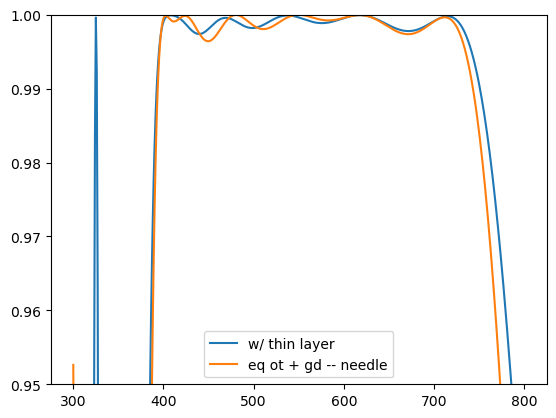

In [4]:
fig, ax = plt.subplots(1, 1)

ax.plot(wls_more, film_init.get_spec(0., wls_more).get_T(), label='w/ thin layer')
ax.plot(wls_more, film_eqot_benchmark.get_spec(0., wls_more).get_T(), label='eq ot + gd -- needle')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot -- ours')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim -- ours')
ax.plot(wls, film_eqot_gd.get_spec().get_T(), label='eq ot_gd -- ours')
ax.plot(wls, film_optim_gd.get_spec().get_T(), label='optim_gd -- ours')
ax.legend()
ax.set_ylim(0.95, 1)
